In [7]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import shutil
import torch
import torch.nn as nn
from  torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import gdown

In [16]:
class BrainDataset(Dataset):
    def __init__(self, img_path, transform=None):
        self.transform = transform
        self.img_path = img_path

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        image = Image.open(self.img_path).convert("RGB")
        image_gray = image.convert("L")  # Convert to grayscale

        if self.transform:
            image_gray = self.transform(image_gray)
        return image_gray


In [17]:
# Create AttU_Net
class conv_block(nn.Module):
    """
    Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):

        x = self.conv(x)
        return x

class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Attention_block(nn.Module):
    """
    Attention Block
    """

    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out


class AttU_Net(nn.Module):
    """
    Attention Unet implementation
    Paper: https://arxiv.org/abs/1804.03999
    """
    def __init__(self, img_ch=3, output_ch=1):
        super(AttU_Net, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)

        #self.active = torch.nn.Sigmoid()


    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        #print(x5.shape)
        d5 = self.Up5(e5)
        #print(d5.shape)
        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

      #  out = self.active(out)

        return out

In [18]:
# Model path
model_path = '/kaggle/input/brain-tumor-unet-zoo/files/checkpoints.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttU_Net(1,1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_state_dict(torch.load(model_path, map_location = device))

<All keys matched successfully>

In [36]:
def visualize_input_output_target(input_image, output_image):
    # Move tensors to CPU memory if they are on CUDA devices
    input_image = input_image.cpu()
    output_image = output_image.cpu()

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    # Plot input image
    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Plot output image (predicted binary mask)
    axes[1].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[1].imshow(output_image.squeeze().numpy(), cmap='jet', alpha=0.5)
    axes[1].set_title('Output Image (Prediction)')
    axes[1].axis('off')

    plt.show()

In [23]:
test_path = '/kaggle/input/brain-tumor-unet-zoo/test2/images/1035_jpg.rf.0dead1ccbe6b1e137ca2d98fc4d34b9a.jpg'

image_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

test_dataset = BrainDataset(test_path, transform=image_transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

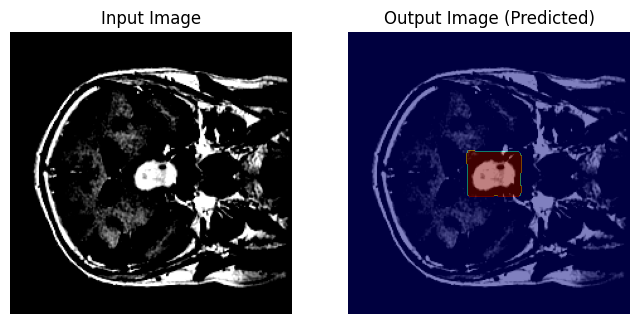

In [33]:
for x in test_loader:
    x = x.to(device, dtype = torch.float32)
    pred = model(x)
    y_pred = (pred > 0.5).float()
    visualize_input_output_target(x[0], y_pred[0])
    break